![Py4Eng](img/logo.png)

# Convolutional Neural Networks with Keras
## Yoav Ram

In this session we will understand:
- how convolutional neural networks work and how they differ from feed forward networks
- how to use Keras as a high-level neural networks library

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras

print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

Keras 2.3.1
GPU: False



Using TensorFlow backend.


# Multilayer Convolutional Network

We build a multilayer convolutional neuron network.

In a convolutional neural network we replace some of the fully-connected layers with convolutional layers in which we apply several convolutional filters to the input.

See this [animation of convolutions](http://cs231n.github.io/assets/conv-demo/index.html).

A convolution is very efficient because parameters of the convolution are shared among all pixels, and the convolution is robust to the position of a feature inside the image.

We'll start by implementing a two-layer network in which the first layer is a convolutional layer and the second layer is a fully-connected softmax layer:
$$
\mathbf{Z_1} = \mathbf{X_1} \ast \mathbf{W_1} + b_1 \\
\mathbf{X_2} = pool({ReLU{(\mathbf{Z_1})}}) $$

$$
\mathbf{Z_2} = \mathbf{X_2} \ast \mathbf{W_2} + b_2 \\
\mathbf{X_3} = pool({ReLU{(\mathbf{Z_2})}}) $$

$$
\mathbf{Z_3} = \mathbf{X_3} \cdot \mathbf{W_3} + b_3 \\
\mathbf{X_4} = ReLU(\mathbf{Z_3}) $$

$$
\mathbf{Z_4} = \mathbf{X_4} \cdot \mathbf{W_4} + b_4 \\
\mathbf{\widehat Y} = softmax(\mathbf{Z_4})
$$

![](http://deeplearning.net/tutorial/_images/mylenet.png)

## Get the data

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [3]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

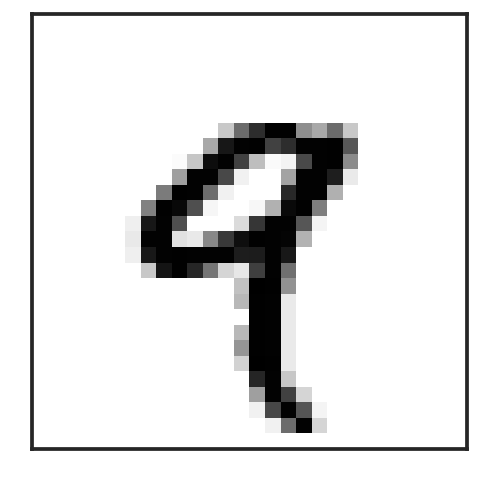

In [4]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[4])

## Keras model

We start by creating a Keras model, the neural network, to which we will add the different layers.
This model is a `Sequential` model, that is, data flows sequentially from one layer to the next.

In [5]:
model = keras.models.Sequential()

## Input layer

In the CNN model our data (the layers) is no longer 2D (`(nsamples, nfeatures)`).
It is now a 4D tensor with shape `(nsamples, width, height, nchannels)`, where `nchannels` can be, for example, 3 for a color image, or 10 for the output of 10 filters.

Note that the first layer in any model must have the `input_shape` parameter that defines the shape of a single input sample. 
Other layers can infer their shape from the previous layers (sequential model!)

The data arrives with just `(nsamples, width, height)` so we have to reshape it to `(nsamples, width, height, 1)` for a single channel (greyscale).

In [6]:
model.add(
    keras.layers.Reshape(target_shape=(width, height, 1), 
                         input_shape=(width, height)))

## First convolutional layer

The first convolutional layer is generated by a convolution with 1 input channel, 32 output channgels, and 5x5 kernels.

The convolution computes 32 features of 5x5 patches; it returns a tensor with shape `(-1, 24, 24, 32)`; 2 pixels are lost from the boundaries.

See this [animation of convolutions](http://cs231n.github.io/assets/conv-demo/index.html).

We then apply a ReLu activation function ($f(x)=max(0,x)$).

In [7]:
model.add(
    keras.layers.Conv2D(32, (5, 5), activation='relu'))

## Pooling

The new element here is the $pool$ function, which applies **pooling** - the combination of several neurons/pixels into a single one.

We will use a common pooling approach called *2x2 max pooling* in which every 2x2 square of pixels is replaced by its maximal value.

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

Pooling adds another non-linear component, reduces the size of the layers, and thus the number of paramters, and reduces over-fitting by approximating the location of feautures.

Since thd activation function operates element-wise without impacting the shape, the output of the activation and pooling has shape `(-1, 12, 12, 32)`.

In [8]:
model.add(
    keras.layers.MaxPool2D())

## Second convolutional layer

We add another convolution + pooling layer, the 2nd layer will have 64 features. The input has 32 channels (from the previous 32 features) but the data arrays are smaller (12x12) due to the previous pooling:

In [9]:
model.add(
    keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())

The data is now is shape `(-1, 4, 4, 64)`.

## Fully connected layer

Now we add a fully-connected layer.
This is done by matrix multiplication with a weight matrix, just like we did with FFN.

But first we need to flatten the input from 4x4x64 to 1,024; then we create a dense layer that connets these 1,024 neurons to the next 1,024 neurons.

In [10]:
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024, activation='relu'))

## Dropout layer

We apply a dropout to reduce overfitting: the dropout stochasticly removes neurons (outputs of the previous layer) and automatically scales the neurons it retained so that their expected sum remains unchanged.

In [11]:
model.add(
    keras.layers.Dropout(rate=0.5))

## Readout layer

We add a Softmax regression layer, similar to the previous, simpler example, by adding a dense layer with softmax activation.

In [12]:
model.add(
    keras.layers.Dense(ncats, activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

## Training

To train the model we need to define the loss function. We'll use the same cross entropy function as before. We also use the same measure for accuracy - we predict the most likelihood class and check that it is the correct label.

We use the [Adam optimizer](http://arxiv.org/pdf/1412.6980.pdf), an algorithm for stochastic gradient descent based on adaptive estimates of first and second moments.

In [14]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

The actual training takes about 6-7 mins on a MacBook Pro 13" 2016 with max specs, reaching accuracy >99% on the validation set.

In [50]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=10, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1323 - acc: 0.9583 - val_loss: 0.0380 - val_acc: 0.9876
Epoch 2/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0444 - acc: 0.9866 - val_loss: 0.0331 - val_acc: 0.9896
Epoch 3/10
60000/60000 [==============================] - 85s 1ms/step - loss: 0.0310 - acc: 0.9903 - val_loss: 0.0267 - val_acc: 0.9924
Epoch 4/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0238 - acc: 0.9927 - val_loss: 0.0310 - val_acc: 0.9904
Epoch 5/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0208 - acc: 0.9935 - val_loss: 0.0313 - val_acc: 0.9916
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0182 - acc: 0.9944 - val_loss: 0.0217 - val_acc: 0.9932
Epoch 7/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0320 - val_acc

The same process take about 30 seconds on my Titan V GPU workstation, or about 1 min on AWS g3.4xlarge virtual machine with Tesla M60 GPU.

In [17]:
# history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=10, 
#     validation_data=(X_test, Y_test),
# ).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1250 - accuracy: 0.9610 - val_loss: 0.0316 - val_accuracy: 0.9894
Epoch 2/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0422 - accuracy: 0.9870 - val_loss: 0.0322 - val_accuracy: 0.9905
Epoch 3/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0315 - accuracy: 0.9903 - val_loss: 0.0289 - val_accuracy: 0.9904
Epoch 4/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.0272 - val_accuracy: 0.9917
Epoch 5/10
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.0286 - val_accuracy: 0.9913
Epoch 6/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0247 - val_accuracy: 0.9926
Epoch 7/10
60000/60000 [==============================]

Interestingly, the neural network very quickly achieves a better accuracy than the previous approach - after one epoch the validation accuracy is > 0.98.
The validation accuracy then fluctuates for a long time around 0.99.

Save the model and the history:

In [18]:
model.save('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

Load model and history:

In [15]:
model = keras.models.load_model('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "rb") as f:
    history = pickle.load(f)

Next, plot the training history.

Note: in some Keras/TensorFlow versions a `KeyError: 'accuracy'` error will be thrown, we can fix it by changing `history['accuracy']` to `history['acc']` and `history['val_accuracy']` to `history['val_acc']`.

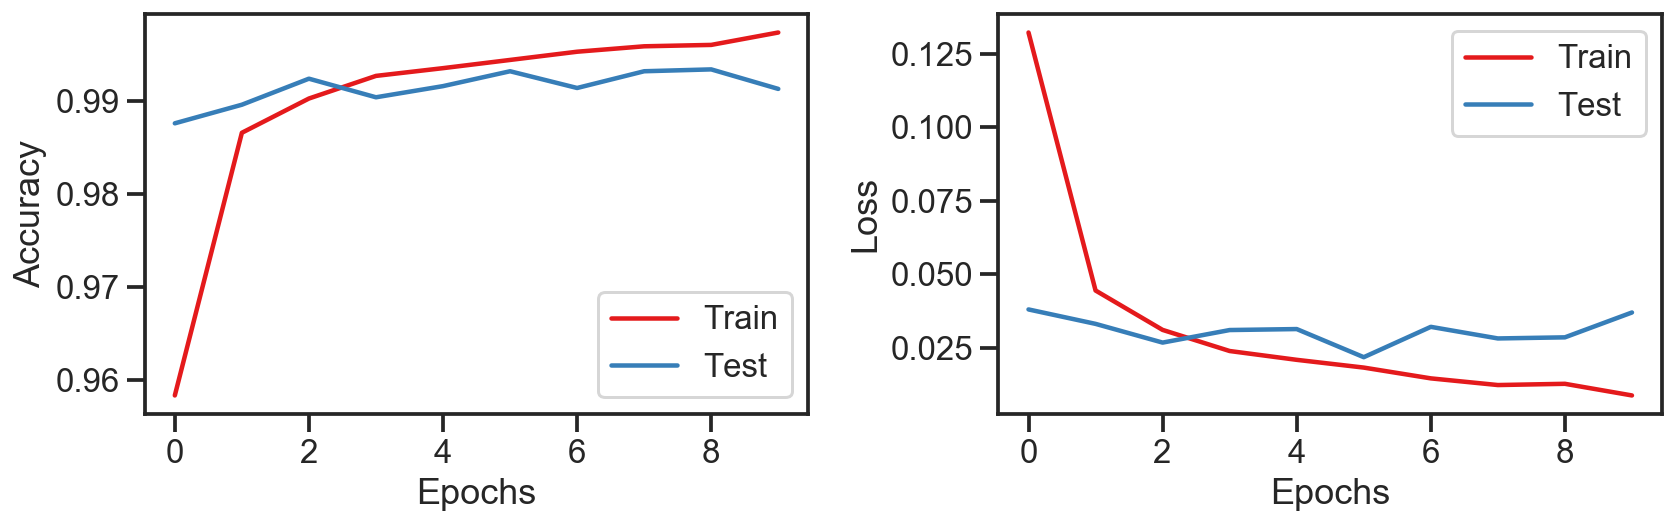

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax = axes[0]
ax.plot(history['accuracy'], label='Train')
ax.plot(history['val_accuracy'], label='Test')
ax.set(ylabel='Accuracy', xlabel='Epochs')
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='Train')
ax.plot(history['val_loss'], label='Test')
ax.set(ylabel='Loss', xlabel='Epochs')
ax.legend()
fig.tight_layout()

# How does it work?

We can use [Shap](https://github.com/slundberg/shap) to interpret the model; follow the link for more explanations.

To install: `conda install -c conda-forge shap`.

If Shap fails with a `keras is no longer supported`, you might be able to run it with a different environment such as `tensorflow2_latest_p37`. This is a [known problem](https://github.com/slundberg/shap/issues/885) with Shap.

In [10]:
import shap

Select a set of background examples to take an expectation over:

In [12]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)

Explain predictions of the model on four images:

In [24]:
idx = range(1, 5)
shap_values = explainer.shap_values(X_test[idx])

Plot the feature attributions:

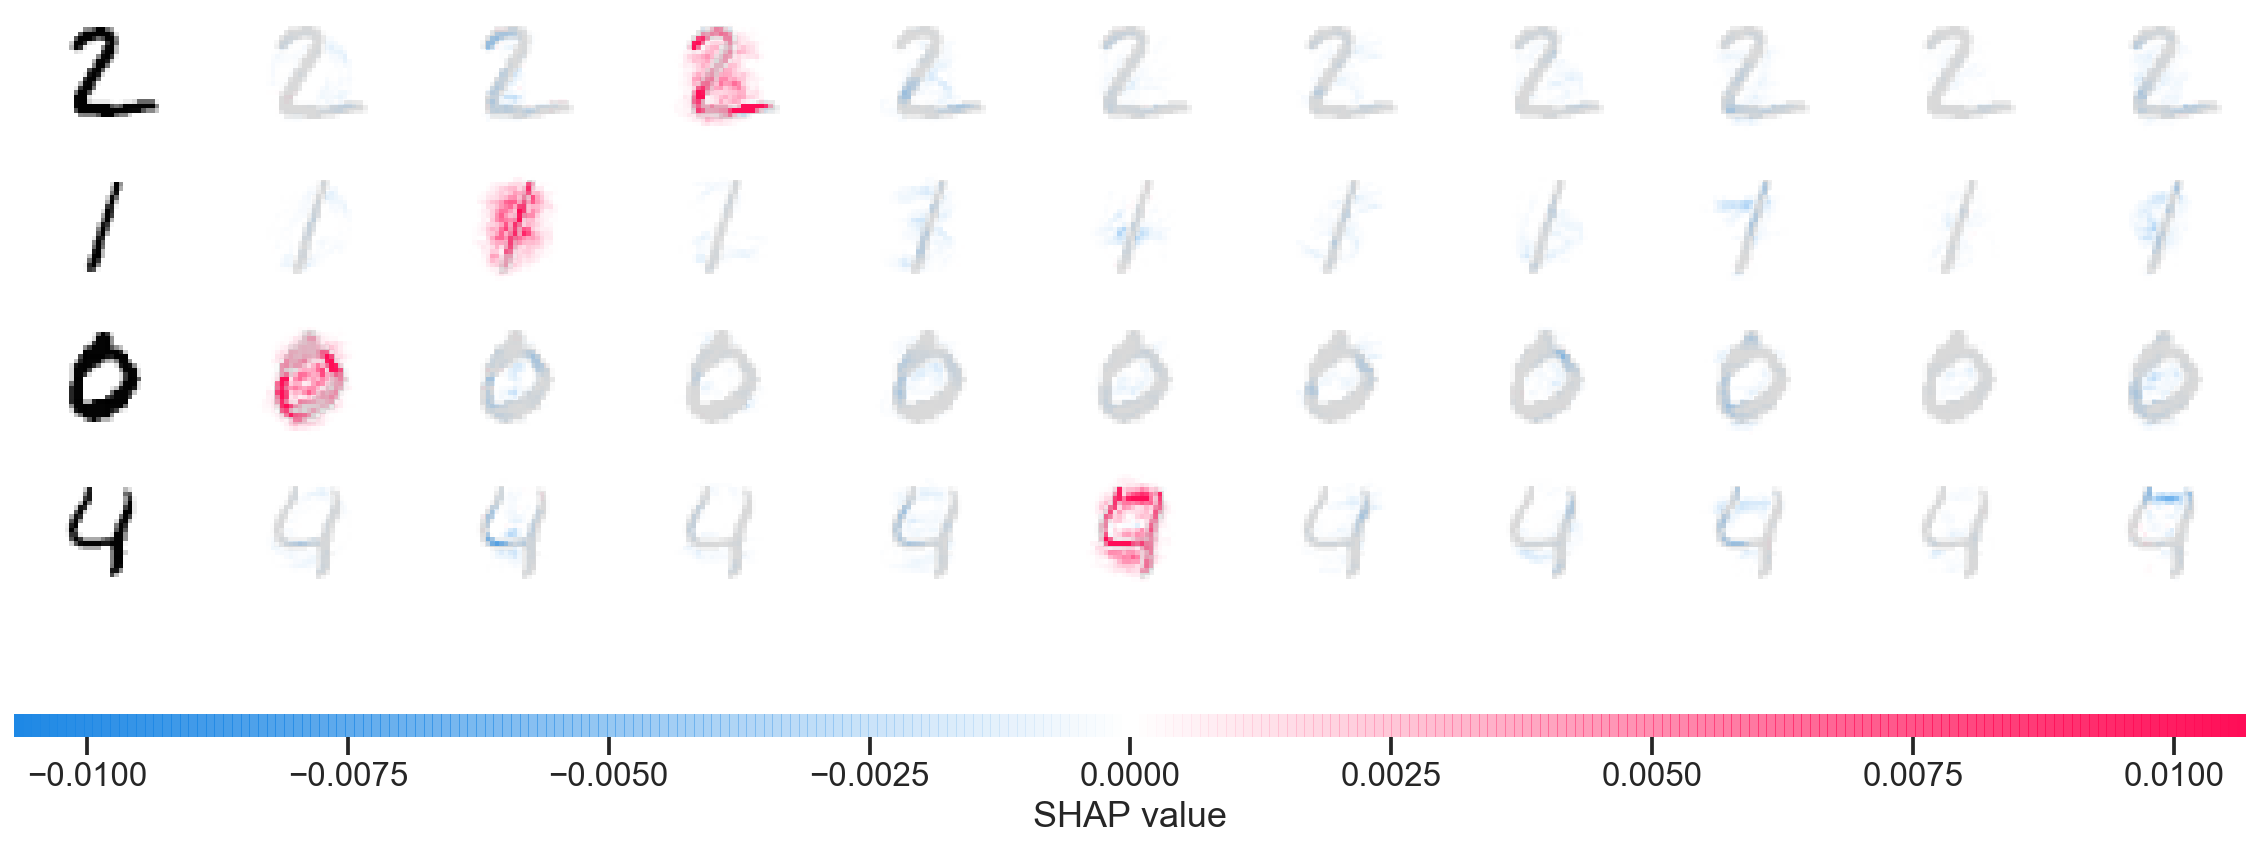

In [25]:
shap.image_plot(shap_values, -X_test[idx])

The plot explains ten possible classes (digits 0-9) for four different images.
These images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations.

The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. 

**Red pixels** increase class prediction.
**Blue pixels** decrease class prediction.

For example, for digit 0 the blank middle is important, and for digit 4 the lack of a connection on top makes it a four instead of a nine.

# References

- [Stanford's CS231n](https://cs231n.github.io/convolutional-networks/) for a brief introduction
- [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 9, for a comprehensive introduction.
- Keras [examples](https://github.com/keras-team/keras/tree/master/examples).
- [Fashion-MNIST CNN exercise](../exercises/CNN.ipynb).
- [Quiver](https://keplr-io.github.io/quiver/) can visualize the network weights.
- [Shap](https://github.com/slundberg/shap): A game theoretic approach to explain the output of any machine learning model.
- [Looking inside neural nets](https://ml4a.github.io/ml4a/looking_inside_neural_nets/)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)